# Import

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from PIL import Image
import os
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    print("GPU available")
else:
    print("GPU not available")

device = torch.device("cuda" if torch.cuda.is_available()
                      else "cpu")

GPU available


# Data Loader

In [3]:
batch_size = 32
num_workers = 2
img_size = 28

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train = MNIST("./mnist", train=True, download=True, transform = transform)

dataloader = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, pin_memory=True)



# Generator

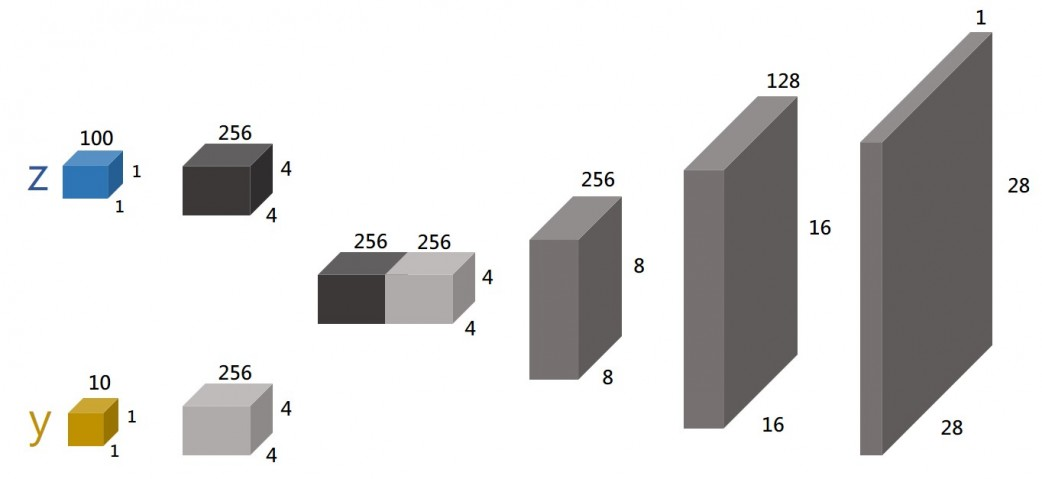

In [4]:
class Generator(nn.Module):
    def __init__(self, input_size=100):
        super(Generator, self).__init__()

        # noise z input layer : (batch_size, 100, 1, 1)
        self.layer_x = nn.Sequential(nn.ConvTranspose2d(in_channels=100, out_channels=128, kernel_size=3, stride=1, padding=0, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    # out size : (batch_size, 128, 3, 3)
                                    )

        # label input layer : (batch_size, 10, 1, 1)
        self.layer_y = nn.Sequential(nn.ConvTranspose2d(in_channels=10, out_channels=128, kernel_size=3,stride=1, padding=0, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    # out size : (batch_size, 128, 3, 3)
                                    )

        # noise z and label concat input layer : (batch_size, 256, 3, 3)
        self.layer_xy = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=0, bias=False),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
                                  nn.Tanh())
                                  # out size : (batch_size, 1, 28, 28)

    def forward(self, x, y):
        x = x.view(x.shape[0], x.shape[1], 1, 1)
        x = self.layer_x(x)

        # y size : (batch_size, 10)
        y = y.view(y.shape[0], y.shape[1], 1, 1)
        y = self.layer_y(y)
        # y size : (batch_size, 128, 3, 3)

        # concat
        xy = torch.cat([x,y], dim=1)
        xy = self.layer_xy(xy)
        # xy size : (batch_size, 1, 28, 28)
        return xy

# Discriminator

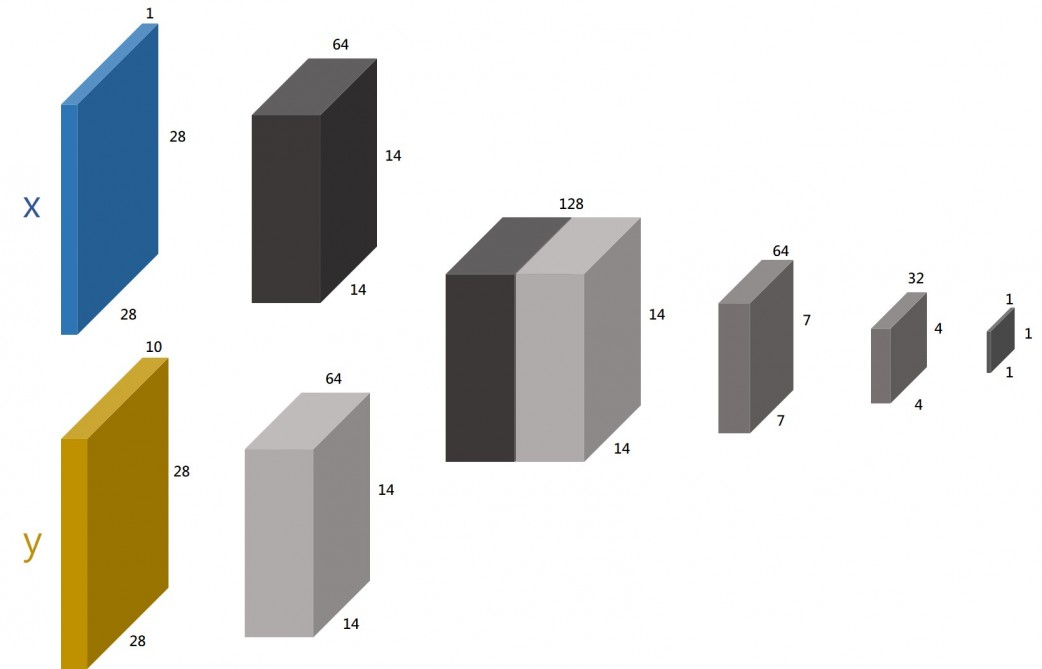

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    # image input, input size : (batch_size, 1, 28, 28)
    self.layer_x = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32,
                                           kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 # out size : (batch_size, 32, 14, 14)
                                )

    # label input, input size : (batch_size, 10, 28, 28)
    self.layer_y = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32,
                                           kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 # out size : (batch_size, 32, 14, 14)
                                 )

    # concat: (batch_size, 64, 14, 14)
    self.layer_xy = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
                               nn.BatchNorm2d(128),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=0, bias=False),
                               nn.BatchNorm2d(256),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=0, bias=False),
                               # out size : (batch_size, 1, 1, 1)
                               nn.Sigmoid()
                               )

  def forward(self, x, y):
      x = self.layer_x(x)

      y = self.layer_y(y)

      xy = torch.cat([x,y], dim=1)
      # size of xy : (batch_size, 64, 14, 14)
      xy = self.layer_xy(xy)
      # size of xy : (batch_size, 1, 1, 1)
      xy = xy.view(xy.shape[0], -1)
      # size of xy : (batch_size, 1)
      return xy

In [6]:
def custom_weights(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

# randomly initialize all weights to mean=0, stdev=0.2.
D = Discriminator().to(device)
G = Generator().to(device)
D.apply(custom_weights)
G.apply(custom_weights)

Generator(
  (layer_x): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_y): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_xy): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

# Training

In [7]:
NUM_EPOCH = 5
size_z = 100
Ksteps = 1
# DCGAN recommend 0.0002 lr
lr = 0.0002
# DCGAN recommend b1 = 0.5
beta1 = 0.5
beta2 = 0.999

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

In [8]:
# labels for training real images on Discriminator
labels_real = torch.ones((batch_size, 1)).to(device)
# labels for generated images G(z) for Discriminator training
labels_fake = torch.zeros((batch_size, 1)).to(device)
# Fix noise for testing generator
z_test = torch.randn(100, size_z).to(device)

In [17]:
onehot = torch.zeros(10, 10).scatter_(1, torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1)
# reshape labels to image size
label_onehot = torch.zeros([10, 10, img_size, img_size])
for i in range(10):
    label_onehot[i, i, :, :] = 1
# create onehot labels for testing generator
test_y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]*10).type(torch.LongTensor)
test_Gy = onehot[test_y].to(device)

In [10]:
D_losses = []
G_losses = []
D_real = []
D_fake = []

step = 0
for epoch in range(NUM_EPOCH):
  epoch_D_losses = []
  epoch_G_losses = []
  epoch_Dx = []
  epoch_DGz = []
  for images, y_labels in dataloader:
    step += 1
    x = images.to(device)
    # preprocess labels
    D_y = label_onehot[y_labels].to(device)
    # forward pass D(x)
    x_preds = D(x, D_y)
    D_x_loss = criterion(x_preds, labels_real)

    # create latent vector z from normal distribution
    z = torch.randn(batch_size, size_z).to(device)
    # create random y labels for generator
    y_gen = (torch.rand(batch_size, 1)*10).type(torch.LongTensor).squeeze()
    G_y = onehot[y_gen].to(device)
    DG_y = label_onehot[y_gen].to(device)

    # generate fake image
    fake_image = G(z, G_y)
    z_preds = D(fake_image.detach(), DG_y)
    D_z_loss = criterion(z_preds, labels_fake)

    # total loss = log(D(x)) + log(1 - D(G(z)))
    D_loss = D_x_loss + D_z_loss

    epoch_D_losses.append(D_loss.item())
    epoch_Dx.append(x_preds.mean().item())

    # zero accumalted grads
    D.zero_grad()
    # do backward pass
    D_loss.backward()
    # update discriminator model
    optimizerD.step()

    # if Ksteps, update generator
    if step % Ksteps == 0:
      z_out = D(fake_image, DG_y)
      G_loss = criterion(z_out, labels_real)
      epoch_DGz.append(z_out.mean().item())
      epoch_G_losses.append(G_loss)

      G.zero_grad()
      G_loss.backward()
      optimizerG.step()
    else:
      # calculate average value for one epoch
      D_losses.append(sum(epoch_D_losses)/len(epoch_D_losses))
      G_losses.append(sum(epoch_G_losses)/len(epoch_G_losses))
      D_real.append(sum(epoch_Dx)/len(epoch_Dx))
      D_fake.append(sum(epoch_DGz)/len(epoch_DGz))

      print(f" Epoch {epoch+1}/{NUM_EPOCH}: D_Loss {D_losses[-1]:.3f} G_Loss {G_losses[-1]:.3f}"
          + f" D_real {D_real[-1]:.3f} D_fake {D_fake[-1]:.3f}")

      G.eval()
    with torch.no_grad():
      # forward pass of G and generated image
      fake_test = G(z_test, test_Gy).cpu()
      # save images in grid of 10 * 10
      torchvision.utils.save_image(fake_test, f"Epoch_{epoch+1}.jpg", nrow=10, padding=0, normalize=True)
    # set generator to training mode
    G.train()

 Epoch 1/5: D_Loss 0.500 G_Loss 2.981 D(x) 0.817 D(G(x)) 0.084
 Epoch 2/5: D_Loss 0.941 G_Loss 1.827 D(x) 0.685 D(G(x)) 0.227
 Epoch 3/5: D_Loss 1.189 G_Loss 1.230 D(x) 0.597 D(G(x)) 0.335
 Epoch 4/5: D_Loss 1.218 G_Loss 1.137 D(x) 0.580 D(G(x)) 0.355
 Epoch 5/5: D_Loss 1.207 G_Loss 1.123 D(x) 0.581 D(G(x)) 0.357


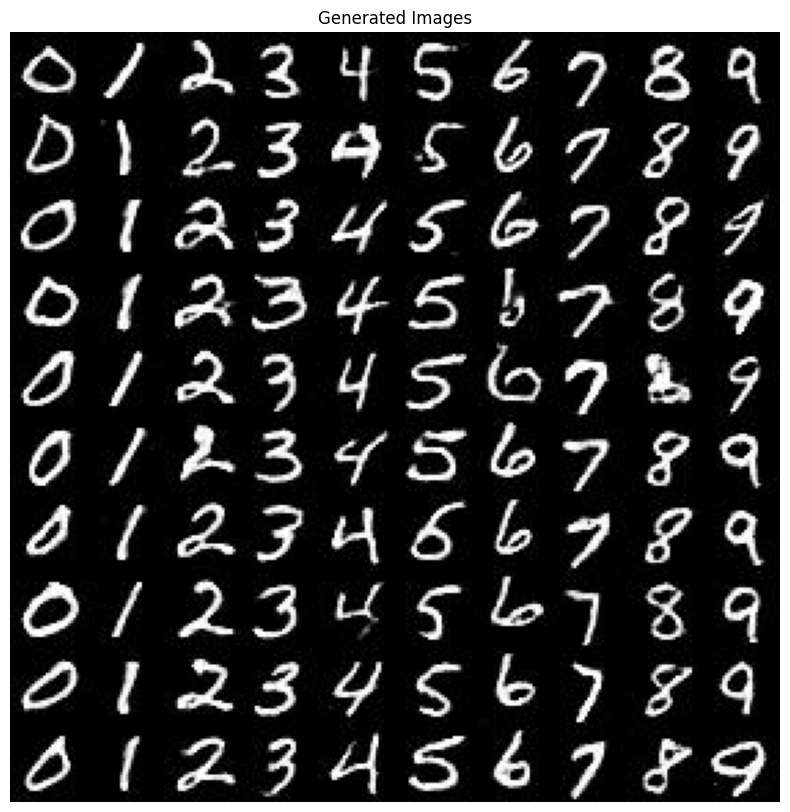

In [11]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
# using _ for avoiding extra outputs
_ = plt.imshow(Image.open(f"Epoch_{NUM_EPOCH}.jpg"))